In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/noise2noise

Mounted at /content/drive
/content/drive/MyDrive/noise2noise


In [ ]:
%reload_ext autoreload

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from noise2noise.training import *
from noise2noise.architectures import *
from noise2noise.helpers import *
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
training_img, _ = load_images()
mean, std = to_float_image(training_img).mean(dim=(0,2,3)), to_float_image(training_img).std(dim=(0,2,3))


to_float_and_normalize = transforms.Compose([ToFloatImage(), transforms.Normalize(mean =mean, std = std)])
to_float = transforms.Compose([ToFloatImage()])


train_loader = DataLoader(
    Noise2NoiseDataset('./dataset/train_data.pkl', 
                       transform=to_float_and_normalize, 
                       target_transform=to_float),
    batch_size = 128,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

validation = DataLoader(
    Noise2NoiseDataset('./dataset/val_data.pkl', 
                       transform=to_float_and_normalize, 
                       target_transform=to_float,  
                       nb_samples=500),
    batch_size = 128,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

In [39]:
model = Unet().to(device)
optim = Adam(model.parameters(), lr=3e-4)

#to remove
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=2e-3, total_steps=1000)

metric = psnr_metric()
criterion = nn.MSELoss()


train_loss, test_loss, unet_psnr = train(model, 
                                           train_loader, 
                                           validation, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=1000, 
                                           samples_steps=100,
                                           lr_scheduler=None)

100%|██████████| 1000/1000 [01:51<00:00,  9.00it/s]


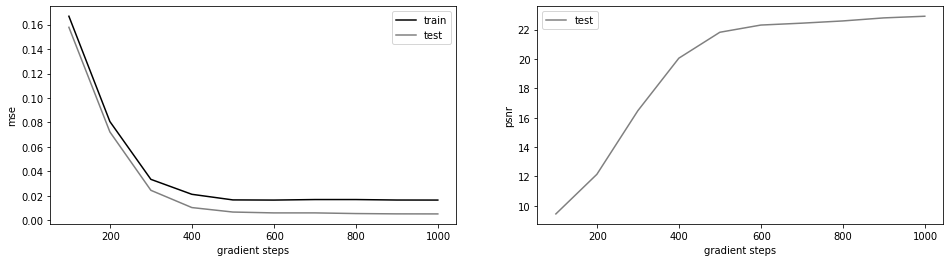

In [40]:
plot_losses(train_loss, test_loss, unet_psnr)

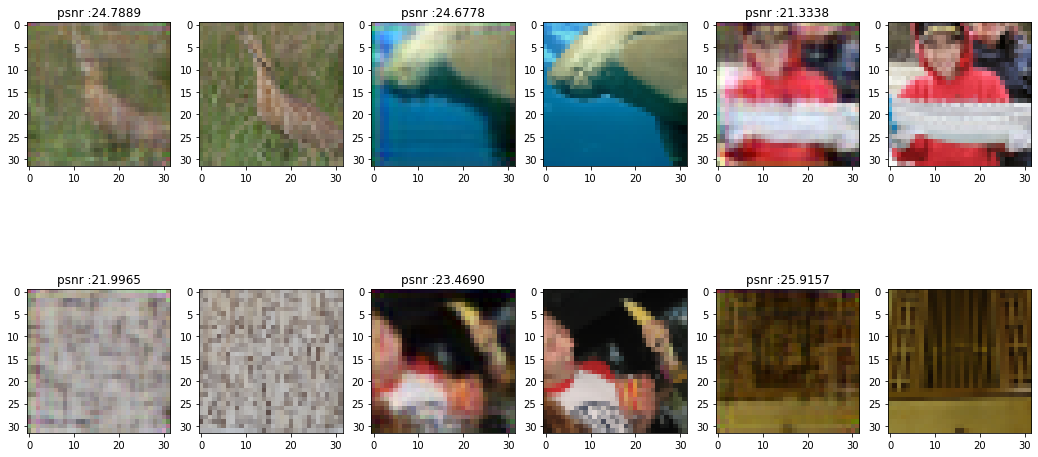

In [41]:
show_results(model, validation, nb_cols=3, nb_rows=2)

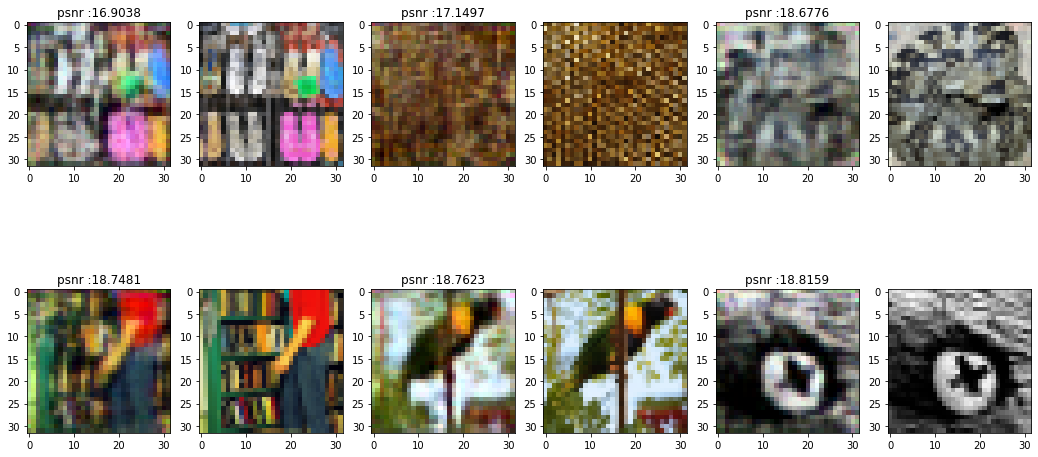

In [42]:
show_worst(model, validation, nb_cols=3, nb_rows=2)

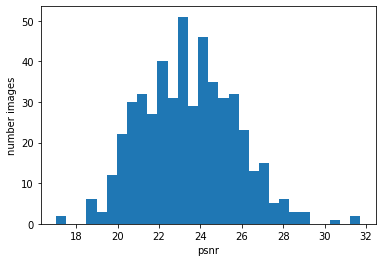

In [43]:
plot_psnr_distribution(model, validation)

In [33]:
model = ResNet().to(device)
optim = Adam(model.parameters(), lr=3e-4)

#to remove
##scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=2e-3, total_steps=1000)

metric = psnr_metric()
criterion = nn.MSELoss()


train_loss, test_loss, resnet_psnr = train(model, 
                                           train_loader, 
                                           validation, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=1000, 
                                           samples_steps=100,
                                           lr_scheduler=None)

100%|██████████| 1000/1000 [02:52<00:00,  5.79it/s]


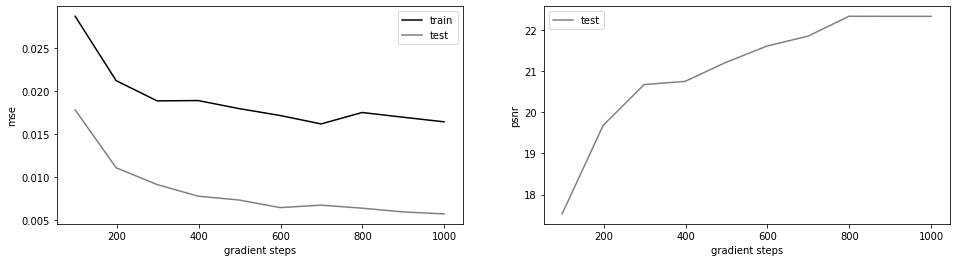

In [34]:
plot_losses(train_loss, test_loss, resnet_psnr)

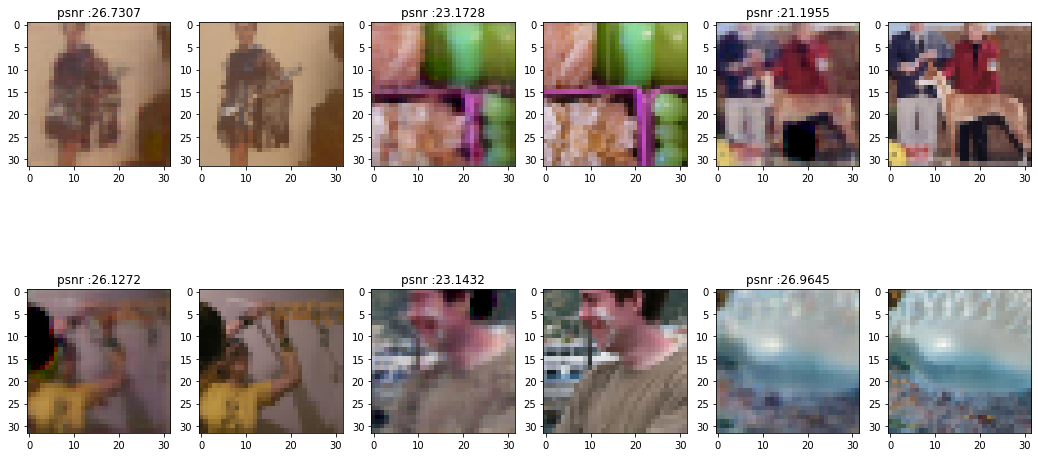

In [35]:
show_results(model, validation, nb_cols=3, nb_rows=2)

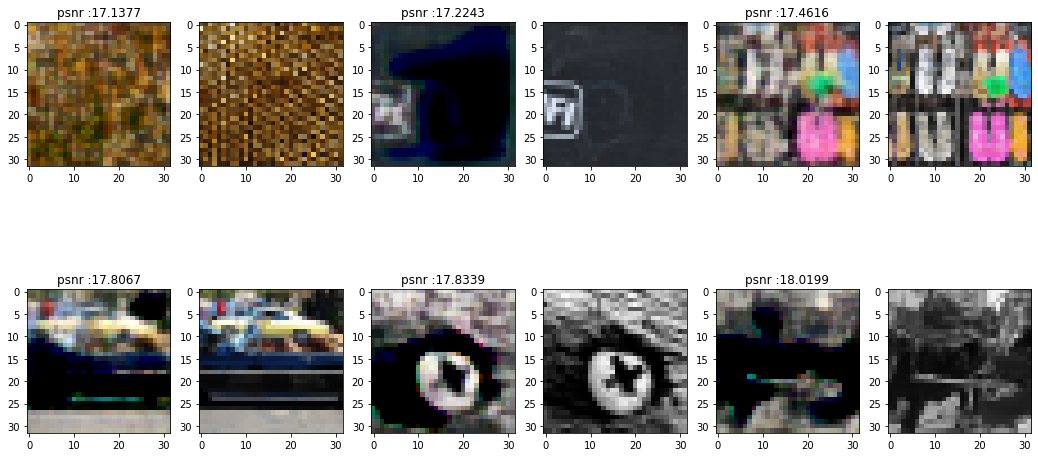

In [36]:
show_worst(model, validation, nb_cols=3, nb_rows=2)

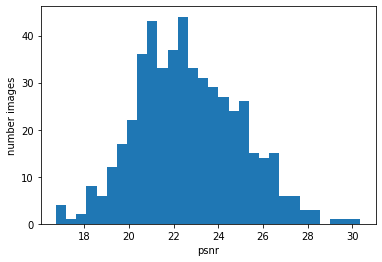

In [37]:
plot_psnr_distribution(model, validation)

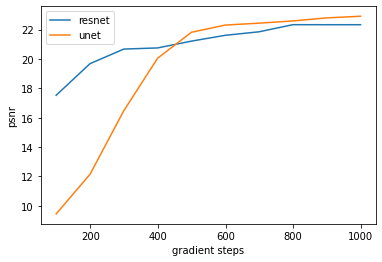

In [44]:
import matplotlib.pyplot as plt

_, axis = plt.subplots()
plot_psnr([resnet_psnr, unet_psnr], ['resnet', 'unet'], axis)